<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons
!pip install nlpaug
!pip install tqdm

     |████████████████████████████████| 686kB 21.5MB/s 


In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import collections

import nlpaug.augmenter.word as naw

import pickle
from tqdm import tqdm

from nlpaug.util import Action

import tensorflow_addons as tfa
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Flatten, RepeatVector, Permute, Activation, Dropout, Bidirectional, Multiply, Lambda

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading data

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_dataset.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv')
df_val = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv')

### Data Augementation

In [8]:
# def augment_text(df,samples=3000,pr=0.2):
#   aug = naw.WordEmbsAug(
#   model_type='glove', model_path='/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt',
#   action="substitute")

#   aug.aug_p=pr
#   new_text=[]
  
#   ##selecting the minority class samples
#   df_n=df[df.Label==1].reset_index(drop=True)

#   ## data augmentation loop
#   for i in tqdm(np.random.randint(0,len(df_n),samples)):
      
#           text = df_n.iloc[i]['Sentences']
#           augmented_text = aug.augment(text)
#           new_text.append(augmented_text)
  
  
#   ## dataframe
#   new=pd.DataFrame({'Sentences':new_text,'Label':0})
#   df=shuffle(df.append(new).reset_index(drop=True))
#   return df

In [9]:
# train = augment_text(df_train)

In [10]:
# train.drop('Unnamed: 0', axis=1, inplace=True)
# train.reset_index(drop=True,inplace=True)

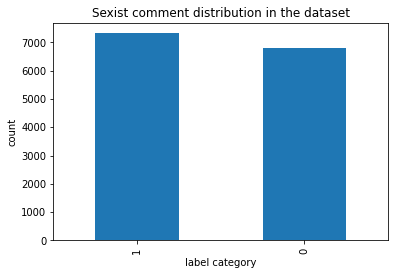

In [ ]:
# train['Label'].value_counts().plot(kind='bar')
# plt.xlabel('label category')
# plt.ylabel('count')
# plt.title('Sexist comment distribution in the dataset after augmentation')
# plt.show()

In [ ]:
# train.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [11]:
df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [12]:
X_train = df_train[['Sentences']]
y_train = df_train['Label']

X_val = df_val[['Sentences']]
y_val = df_val['Label']

X_test = df_test[['Sentences']]
y_test = df_test['Label']

In [13]:
X_train.tail()

,Sentences
14106,having to state your marital status times a d...
14107,my mother commenting on my outfit dont cry to ...
14108,a good man acknowledges a woman than another p...
14109,agree to an extent
14110,joker doesnt even work with a woman besides wa...


In [14]:
X_train.shape, X_val.shape, X_test.shape

((14111, 1), (273, 1), (228, 1))

In [ ]:
#!unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

### Loading the Gender neutral GLoVe embedding

In [28]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [29]:
embedding_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [30]:
word_to_vec_map['and'].shape

(300,)

In [31]:
vocab = list(words_to_index.keys())

In [32]:
len(vocab)

142527

### Getting word embeddigs for the input data - X_train and X_test

In [20]:
def get_tokens_embedding_list(data, vocab, word_to_vec_map):
  embedding_list = []
  for sent_seq in data:
    tensor_list=[]
    for word in sent_seq[0].split():
      if word in vocab:
        tensor_list.append(word_to_vec_map[word])
        #print(len(tensor_list))
    embedding_list.append(tensor_list)
  return embedding_list

In [21]:
X_train_embedding = get_tokens_embedding_list(X_train.values, vocab, word_to_vec_map)

In [22]:
X_val_embedding = get_tokens_embedding_list(X_val.values, vocab, word_to_vec_map)

In [23]:
X_test_embedding = get_tokens_embedding_list(X_test.values, vocab, word_to_vec_map)

In [24]:
with open('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_embedding_list_1', 'wb') as f:
  pickle.dump(X_train_embedding, f)

In [25]:
with open('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_embedding_list_1', 'rb') as f:
  X_train_embedding = pickle.load(f)

In [26]:
def create_dataset(data_in, target_in):
   
    #Get the length of each sentence
    N = [len(data_in[i]) for i, _ in enumerate(data_in)]
    embedding_size = 300
    tensor_N = tf.constant(N, tf.int32)
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    print(ragged_input.shape)

    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, target_in))
    del ragged_input

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    
    # Transform_pad function is defined above; you can change the num_parallel_calls
    dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, embedding_size]), y), num_parallel_calls=3)   
                          
    dataset = dataset.prefetch(1)
    return dataset

In [27]:
train_dataset = create_dataset(X_train_embedding, y_train)
val_dataset = create_dataset(X_val_embedding, y_val)

(14111, None, None)
(273, None, None)


In [33]:
train_dataset

<PrefetchDataset shapes: ((None, None, 300), (None,)), types: (tf.float32, tf.int64)>

### Define the model

In [70]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)
bid_lstm_2 = Bidirectional(LSTM(128, return_sequences=False))(dropout_1)
dropout_2 = Dropout(0.5)(bid_lstm_2)
dense = Dense(1, activation='sigmoid')(dropout_2)

lstm_model = Model(inputs=input_layer, outputs=dense)

In [71]:
lstm_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 256)         439296    
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 833,793
Trainable params: 833,793
Non-trainable params: 0
_____________________________________________________

In [72]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='bce', metrics=['accuracy'])

In [73]:
history = lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)

Epoch 1/10
221/221 [==============================] - 27s 104ms/step - loss: 0.6189 - accuracy: 0.6620 - val_loss: 0.6988 - val_accuracy: 0.5531
Epoch 2/10
221/221 [==============================] - 22s 101ms/step - loss: 0.5685 - accuracy: 0.7108 - val_loss: 0.6235 - val_accuracy: 0.6484
Epoch 3/10
221/221 [==============================] - 22s 101ms/step - loss: 0.5470 - accuracy: 0.7239 - val_loss: 0.5959 - val_accuracy: 0.7070
Epoch 4/10
221/221 [==============================] - 22s 100ms/step - loss: 0.5290 - accuracy: 0.7342 - val_loss: 0.5872 - val_accuracy: 0.7070
Epoch 5/10
221/221 [==============================] - 22s 101ms/step - loss: 0.5161 - accuracy: 0.7421 - val_loss: 0.5894 - val_accuracy: 0.6923
Epoch 6/10
221/221 [==============================] - 23s 103ms/step - loss: 0.5041 - accuracy: 0.7498 - val_loss: 0.5867 - val_accuracy: 0.7070
Epoch 7/10
221/221 [==============================] - 22s 102ms/step - loss: 0.5061 - accuracy: 0.7502 - val_loss: 0.5987 - val_ac

In [76]:
def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    for i, metric in enumerate(['loss', 'accuracy']): 
        ax[i].plot(history.history[metric], label='Train')
        ax[i].plot(history.history['val_'+metric], label='Validation')
        if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel(metric)
    plt.suptitle(f'{name} Training', y=1.05)
    plt.legend()
    plt.tight_layout()

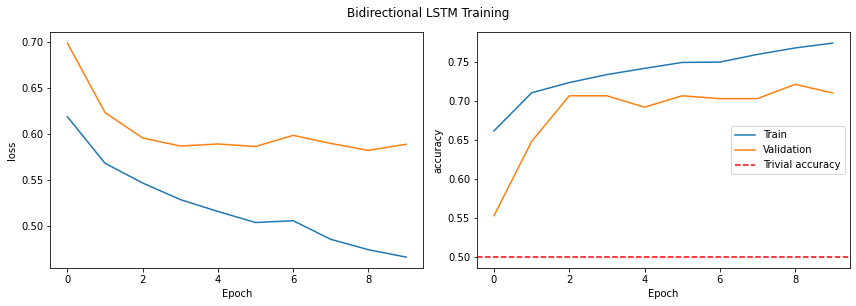

In [77]:
plot_history(history, 'Bidirectional LSTM')

In [78]:
lstm_model.save('/content/drive/MyDrive/AI-3 Project/Models/lstm_model_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_model_1/assets


In [79]:
lstm_model = load_model('/content/drive/MyDrive/AI-3 Project/Models/lstm_model_1')

In [80]:
ragged_input_test  = tf.ragged.constant(X_test_embedding, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((ragged_input_test, y_test.values))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(1)
test_dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, 300]),y), num_parallel_calls=3)


In [81]:
loss, acc = lstm_model.evaluate(test_dataset)

228/228 [==============================] - 2s 5ms/step - loss: 0.6157 - accuracy: 0.7105


## Model with attention

In [116]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)

attention = Dense(1, activation='tanh')(dropout_1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(128 * 2)(attention)
attention = Permute([2, 1])(attention)

sent_representation = Multiply()([dropout_1, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

dropout_2 = Dropout(0.5)(sent_representation)
dense = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=input_layer, outputs=dense)

In [117]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, None, 256)    439296      input[0][0]                      
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, None, 256)    0           bidirectional_17[0][0]           
__________________________________________________________________________________________________
dense_19 (Dense)                (None, None, 1)      257         dropout_24[0][0]                 
___________________________________________________________________________________________

In [118]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='bce', metrics=['accuracy'])

In [119]:
history_1 = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)

Epoch 1/10
221/221 [==============================] - 18s 64ms/step - loss: 0.6545 - accuracy: 0.6237 - val_loss: 0.6899 - val_accuracy: 0.5714
Epoch 2/10
221/221 [==============================] - 14s 62ms/step - loss: 0.6009 - accuracy: 0.6876 - val_loss: 0.6322 - val_accuracy: 0.6557
Epoch 3/10
221/221 [==============================] - 14s 63ms/step - loss: 0.6171 - accuracy: 0.6627 - val_loss: 0.6391 - val_accuracy: 0.6300
Epoch 4/10
221/221 [==============================] - 14s 63ms/step - loss: 0.6180 - accuracy: 0.6786 - val_loss: 0.6273 - val_accuracy: 0.6337
Epoch 5/10
221/221 [==============================] - 14s 64ms/step - loss: 0.6012 - accuracy: 0.6892 - val_loss: 0.6247 - val_accuracy: 0.6667
Epoch 6/10
221/221 [==============================] - 14s 63ms/step - loss: 0.5923 - accuracy: 0.6985 - val_loss: 0.6244 - val_accuracy: 0.6484
Epoch 7/10
221/221 [==============================] - 13s 60ms/step - loss: 0.5762 - accuracy: 0.7064 - val_loss: 0.6230 - val_accuracy:

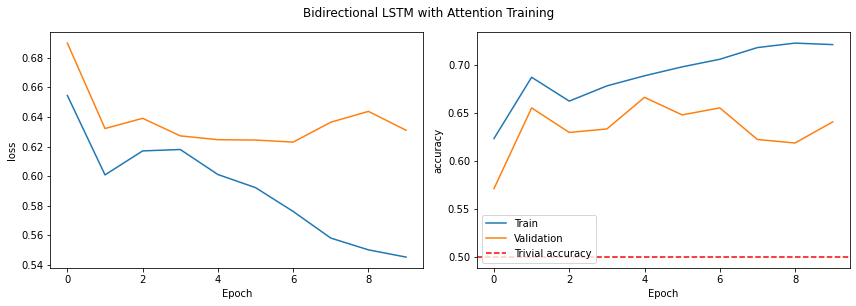

In [120]:
plot_history(history_1, 'Bidirectional LSTM with Attention')

In [121]:
model.save('/content/drive/MyDrive/AI-3 Project/Models/lstm_with_attention_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_with_attention_1/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_with_attention_1/assets


In [122]:
model = load_model('/content/drive/MyDrive/AI-3 Project/Models/lstm_with_attention_1')

In [123]:
loss, acc = model.evaluate(test_dataset)

228/228 [==============================] - 2s 4ms/step - loss: 0.6263 - accuracy: 0.6711


### Script to get the data for everyday Sexism project

In [ ]:
!pip install ipdb

     |████████████████████████████████| 788kB 9.8MB/s 
     |████████████████████████████████| 368kB 21.9MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.8-cp37-none-any.whl size=11599 sha256=d839fd73980ff3fe86fe9f9ed5af4b3dc5f8d906d28d4410b1267be7ab091db3
  Stored in directory: /root/.cache/pip/wheels/0d/d6/5a/2fdf30b75ca5099e18f66a0a4d439ba031e1aa239e12b39c24
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.23.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [ ]:
!apt-get install libmagic-dev
!pip install python-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 1s (227 kB/s)
Selecting previously unselected package libmagic-m

In [ ]:
!pip install ftfy

     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=716904f52b70aaf841cf383a11fe4f203a4e08021cda22b0b21c2ad60ba7f1fe
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [ ]:
# Example use: python script.py data_placeholders.tsv data.tsv
import re
import urllib.request as urllib2
import os
import ipdb
from bs4 import BeautifulSoup
import time
import sys
import codecs
import pandas as pd
import csv
import json
from os import listdir
from os.path import isfile, join
import io
import magic
import pickle
import ftfy

tsv_filepath = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data_placeholders.tsv'
data_write_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data.tsv'


def find_post_id(name_box):
    classes = name_box['class']
    for _class in classes:
        if _class[:5] == "post-" and len(_class) > 5:
            return int(_class[5:])
    return -1


def crawl_post(post_page, post_number):
    crawl_page = post_page + str(post_number)

    isCrawledSuccessfully = False
    while not isCrawledSuccessfully:
        try:
            page = urllib2.urlopen(crawl_page).read()
            isCrawledSuccessfully = True
        except urllib2.HTTPError as e:
            if e.code == 404:
                print("\t\t>>> Found 404")
                return None
            else:
                print("\t\t>>> Waitiing for 30 seconds")
                time.sleep(30)
        except Exception:
            print("\t\t>>> Waitiing for 30 seconds")
            time.sleep(30)

    soup = BeautifulSoup(page, 'html.parser')
    name_boxes = soup.find_all('article', attrs={'class': 'post'})
    assert len(name_boxes) == 1
    for i, name_box in enumerate(name_boxes):
        post_id = find_post_id(name_box)
        if post_id == -1:
            print("\t\t>>> ERROR: Error fetching post_id")
            return None
        
        #TODO: VERIFY IF THIS IS CORRECT
        soup = BeautifulSoup(name_box.encode("utf-8"), 'html.parser')
        _name_box = soup.find('div', attrs={'class': 'entry-content'})
        post = _name_box.get_text()
        post = post.replace('\n', '<br/>')
    return post


import re

r_white = re.compile(r'\s+')

xml_csv = open(data_write_path, 'w')
csv_writer = csv.writer(xml_csv, delimiter='\t')
csv_writer.writerow(['post', 'labels'])

post_id_dict = {}

with open(tsv_filepath, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        labels = row[1]
        parts = row[0].split("__")
        post_id__str = parts[0]
        post_offsets__str = [offset.split("_") for offset in parts[1:]]

        if post_id__str in post_id_dict:
            print("accessing " + post_id__str)
            post_text = post_id_dict[post_id__str]
        else:
            print("fetching " + post_id__str)
            post_text = crawl_post("https://everydaysexism.com/everyday-sexism/", post_id__str)
            if post_text == None:
                continue
            post_id_dict[post_id__str] = post_text

        post_text = post_text.replace('<br/>', ' ')
        post_text = re.sub(' +', ' ', post_text)
        post_text = post_text.lstrip()
        post_text__fixed = ftfy.fix_text(post_text)
        text = ""
        for index in range(len(post_offsets__str)):
            text = text + post_text__fixed[int(post_offsets__str[index][0]):int(post_offsets__str[index][1]) + 1]
            if len(post_offsets__str) > 1 and len(post_offsets__str) != index + 1:
                text = text + " "
        text = r_white.sub(' ', text)
        text = text.strip()
        csv_writer.writerow([text, labels])

xml_csv.close()

In [ ]:
df_es = pd.read_csv(data_write_path, sep='\t')